In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import geopandas as gpd, descartes
import itertools
import os

# Checkout ACS, WA 2018. BG select by relative 65+ density

https://data.census.gov/cedsci/advanced
- Geography
- Tract
- Washington
- King County
- All Census [Block groups] within King County
- Table B0101

Info on census geographies: https://factfinder.census.gov/help/en/tutorials/introduction_to_geographies_tutorial.htm

More info with viz of census blocks: http://proximityone.com/geo_blocks.htm

## Create dict of all blockgroups each blockgroup touches

In [2]:
# read in shapefile. these are blockgoup level, washington 2018
# https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2018&layergroup=Block+Groups
wa_bg = gpd.read_file('/home/j/temp/beatrixh/sim_science/census_GIS/tl_2018_53_bg/tl_2018_53_bg.shp')

In [3]:
# maybe want this to be an int?
wa_bg.GEOID = wa_bg.GEOID.astype(int)

In [4]:
N = wa_bg.shape[0]

In [5]:
%%time
nbs = {wa_bg.iloc[i,4]:[] for i in range(N)}

CPU times: user 47.1 ms, sys: 4.98 ms, total: 52.1 ms
Wall time: 47 ms


In [6]:
%%time

for i in range(N):
    for j in range(i+1,N):
        if wa_bg.geometry[i].intersects(wa_bg.geometry[j]):
            nbs[wa_bg.iloc[i,4]] = nbs[wa_bg.iloc[i,4]] + [wa_bg.iloc[j,4]]
            nbs[wa_bg.iloc[j,4]] = nbs[wa_bg.iloc[j,4]] + [wa_bg.iloc[i,4]]


CPU times: user 8min 25s, sys: 3.31 s, total: 8min 28s
Wall time: 8min 26s


In [7]:
# %%time
# nbs2 = {wa_bg.iloc[i,4]:[] for i in range(N)}

In [8]:
# %%time
# #todo: fix range to exclude self
# for i in range(N):
#     neighb = [wa_bg.iloc[j,4] for j in range(N) if wa_bg.geometry[i].intersects(wa_bg.geometry[j])]
#     nbs2[wa_bg.iloc[i,4]] = neighb

In [9]:
wa_bg.GEOID = wa_bg.GEOID.astype(str)
king_bg = wa_bg[wa_bg.GEOID.str[:5]=='53033']

In [10]:
wa_bg.GEOID = wa_bg.GEOID.astype(int)
king_bg.GEOID = wa_bg.GEOID.astype(int)

/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [11]:
%%time
king_nbs = {king_bg.iloc[i,4]:[] for i in range(king_bg.shape[0])}

for i in range(king_bg.shape[0]):
    for j in range(i+1,king_bg.shape[0]):
        if king_bg.iloc[i,].geometry.intersects(king_bg.iloc[j,].geometry):
            king_nbs[king_bg.iloc[i,4]] = king_nbs[king_bg.iloc[i,4]] + [king_bg.iloc[j,4]]
            king_nbs[king_bg.iloc[j,4]] = king_nbs[king_bg.iloc[j,4]] + [king_bg.iloc[i,4]]

CPU times: user 5min 53s, sys: 1.11 s, total: 5min 54s
Wall time: 5min 54s


## Load age count data (king county)

In [17]:
os.listdir("/home/j/temp/beatrixh/sim_science/ACS_2018/ACSD/")

['ACSDT5Y2018.B01001_data_with_overlays_2020-03-24T190213.csv',
 'ACSDT5Y2018.B01001_table_title_2020-03-24T190213.txt',
 'ACSDT5Y2018.B01001_metadata_2020-03-24T190213.csv']

In [18]:
metadata = pd.read_csv("/home/j/temp/beatrixh/sim_science/ACS_2018/ACSD/ACSDT5Y2018.B01001_metadata_2020-03-24T190213.csv")
data = pd.read_csv("/home/j/temp/beatrixh/sim_science/ACS_2018/ACSD/ACSDT5Y2018.B01001_data_with_overlays_2020-03-24T190213.csv")

## look for counts of 65+

In [19]:
# grab vars corresponding to male or female >=65
older_ages = metadata[((metadata.id.str.contains('years')) & (metadata.id.str.contains('Estimate'))) &
                      ((metadata.id.str.contains('!65'))|(metadata.id.str.contains('!67'))|
                       (metadata.id.str.contains('!7'))|(metadata.id.str.contains('!8')))].GEO_ID
older_ages = list(older_ages)

In [20]:
# grab geo cols plus >=65 cols
# but get rid of top row (var descriptions; can't sum)
older_df = data[['GEO_ID','NAME'] + older_ages][data.GEO_ID!='id']

In [21]:
# convert to ints and sum
older_df[older_ages] = older_df[older_ages].astype(int)
older_df['over_65'] = older_df.iloc[:,2:].sum(axis=1)

In [23]:
# add back on tota population counts and subset
counts = older_df[['GEO_ID','NAME','over_65']].merge(data[['GEO_ID','B01001_001E']], on = 'GEO_ID',
                                    how = 'left')
counts = counts.rename(columns = {'B01001_001E' : 'total'})
counts['total'] = df['total'].astype(int)

In [24]:
counts['prop_over_65'] = counts['over_65'] / counts['total']

In [25]:
counts = counts.sort_values('prop_over_65', ascending=False)

In [43]:
counts['lmax'] = 0

In [27]:
counts['GEO_ID'] = counts['GEO_ID'].str[9:]

In [28]:
counts.GEO_ID = counts.GEO_ID.astype(int)

In [29]:
#are all my king county geoids in my WA geoids?
np.setdiff1d(counts.GEO_ID, wa_bg.GEOID).shape

(0,)

In [44]:
counts.head()

,GEO_ID,NAME,over_65,total,prop_over_65,lmax
127,530330322082,"Block Group 2, Census Tract 322.08, King Count...",639,924,0.691558,0
996,530330323271,"Block Group 1, Census Tract 323.27, King Count...",2120,3391,0.625184,0
1117,530330063002,"Block Group 2, Census Tract 63, King County, W...",600,1195,0.502092,0
1114,530330105001,"Block Group 1, Census Tract 105, King County, ...",532,1124,0.473310,0
838,530330290011,"Block Group 1, Census Tract 290.01, King Count...",387,821,0.471376,0


In [42]:
counts.iloc[5,5]

1

In [45]:
%%time

for i in range(counts.shape[0]): #for each blockgroup
    denom = counts[counts.GEO_ID.isin(king_nbs[counts.iloc[i,0]])].total.sum() #total population in counties surrounding
    num = counts[counts.GEO_ID.isin(king_nbs[counts.iloc[i,0]])].over_65.sum() #total >=65 pop in counties surrounding
    if counts.iloc[i,4] > (num/denom):
        counts.iloc[i,5] = 1

CPU times: user 2.47 s, sys: 11.9 ms, total: 2.48 s
Wall time: 2.48 s


In [47]:
counts.lmax.sum()

683

## check against known skilled nursing facilities

In [49]:
snfs = pd.read_csv('/homes/beatrixh/repos/geomatch/king_county_03_30_2020/king_county_geocode_for_vetting.csv')

In [50]:
snfs.head()

,Unnamed: 0,address,lat,lon,best_lat,best_long
0,0,"805 FRONT ST SOUTH, ISSAQUAH, WA,",47.522125,-122.034225,47.521655,-122.034809
1,1,"901 12TH AVENUE, SEATTLE, WA",47.610485,-122.316790,47.610229,-122.317629
2,2,"491 SOUTH 338TH STREET, FEDERAL WAY, WA,",47.298603,-122.326700,47.298048,-122.326598
3,3,"1334 TERRY AVENUE, SEATTLE, WA,",47.611380,-122.328540,47.611873,-122.328573
4,4,"135 SOUTH 336TH STREET, FEDERAL WAY, WA,",47.299880,-122.328480,47.298797,-122.331097


In [134]:
# turn into geodataframe for plotting
king_beds = gpd.GeoDataFrame(snfs, geometry=gpd.points_from_xy(snfs.best_long,snfs.best_lat))

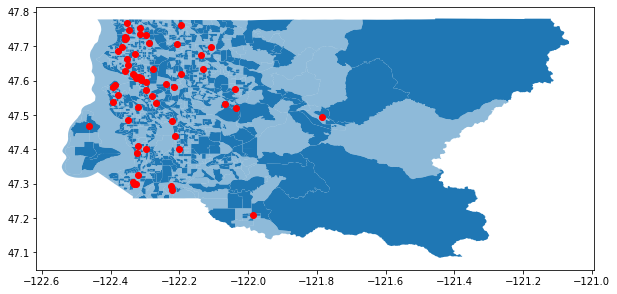

In [133]:
fig, ax = plt.subplots(figsize = (10,10))

bgroups1.plot(ax=ax) #plot blockgroups with more >=65 y.o.s
bgroups0.plot(ax=ax, alpha=0.5) #plot blockgroups with fewer <=65 y.o.s
king_beds.plot(ax=ax, color='red') #plot snfs

plt.show()

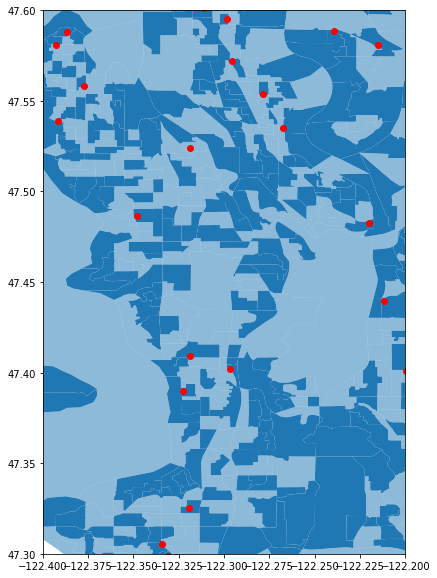

In [137]:
#zoom in
fig, ax = plt.subplots(figsize = (10,10))

ax.set_xlim(-122.4, -122.2)
ax.set_ylim(47.3, 47.6)

bgroups1.plot(ax=ax) #plot king county map
bgroups0.plot(ax=ax, alpha=0.5) #plot king county map
king_beds.plot(ax=ax, color='red') #plot snfs

plt.show()

##  determine % of snfs hit

In [634]:
# first merge geometries onto object with # elderly + guesses

# then..
# get df of skilled nfs
# add column for 'hit', set to 0
# add column for 'which', set to ''
# iterate through. for each intersection, hit +=1, which += ' geoid'

In [59]:
snf_prelim = king_beds[['best_lat','best_long','geometry']]

In [60]:
# merge geometries onto df with geoids counts and guesses
blockgroups_king = counts.merge(king_bg[['GEOID', 'geometry']], left_on = 'GEO_ID', right_on = 'GEOID', how = 'outer')
blockgroups_king = blockgroups_king.drop('GEO_ID', axis = 1)

In [61]:
# make sure this is the counts df with geometry added
print(blockgroups_king.shape)
print(counts.shape)
print(blockgroups_king.columns)

(1422, 7)
(1422, 6)
Index(['NAME', 'over_65', 'total', 'prop_over_65', 'lmax', 'GEOID',
       'geometry'],
      dtype='object')


In [704]:
# recall:
# king_nbs is a dict of GEOIDS of neighbors of each blockgroup, restricted to king county
# blockgroups_king is gdf with GEO_IDs in king county, geometries, the counts of >=65s, and guesses (lmax) as to snfs
# snf_prelim is a geodataframe with locations of snfs in king county

In [68]:
# create cols to hold geoids associated with each snf
snf_prelim['true_pos'] = ''
snf_prelim['false_neg'] = ''

for i in range(snf_prelim.shape[0]): #loop through snfs
    for j in range(blockgroups_king.shape[0]): #loop through blockgroups
        if snf_prelim.iloc[i,].geometry.intersects(blockgroups_king.iloc[j].geometry): #if there's an intersection
            if blockgroups_king.iloc[j].lmax==1:
                snf_prelim.iloc[i,-2] += str(blockgroups_king.iloc[j,].GEOID) + ' ' #add to true pos
            else:
                snf_prelim.iloc[i,-1] += str(blockgroups_king.iloc[j,].GEOID) + ' ' #add to false neg

/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on 

In [115]:
snf_geoids = snf_prelim[snf_prelim.true_pos!=''].true_pos.append([snf_prelim[snf_prelim.false_neg!=''].false_neg])

In [116]:
counts['has_snf'] = 0
counts.loc[counts.GEO_ID.isin(snf_geoids.astype(int)),'has_snf'] = 1

In [131]:
print(f'sensitivity (% of snfs identified): {counts[(counts.lmax==1) & (counts.has_snf==1)].shape[0]/counts[(counts.has_snf==1)].shape[0]}')

sensitivity (% of snfs identified): 0.7586206896551724


In [132]:
print(f'specificity (% of non-snf blockgroups identified): {counts[(counts.lmax==0) & (counts.has_snf==0)].shape[0]/counts[(counts.has_snf==0)].shape[0]}')

specificity (% of non-snf blockgroups identified): 0.531524926686217


In [126]:
print(f'precision (true positives/all positives): {counts[(counts.lmax==1) & (counts.has_snf==1)].shape[0]/counts[(counts.lmax==1)].shape[0]}')

precision (true positives/all positives): 0.06442166910688141


In [128]:
print(f'negative predictive value (true negatives/all negatives): {counts[(counts.lmax==0) & (counts.has_snf==0)].shape[0]/counts[(counts.lmax==0)].shape[0]}')

negative predictive value (true negatives/all negatives): 0.9810554803788903


In [130]:
print(f'rate of snfs in blockgroups: {counts[counts.has_snf==1].shape[0]/counts.shape[0]}')

rate of snfs in blockgroups: 0.040787623066104076


## for next time

In [53]:
bgroups1 = wa_bg[wa_bg.GEOID.isin(counts[counts.lmax==1].GEO_ID)]
bgroups0 = wa_bg[wa_bg.GEOID.isin(counts[counts.lmax==0].GEO_ID)]

In [846]:
# this should be spatial union of positives & negatives
more_elderly = bgroups1.dissolve(by='STATEFP')
less_elderly = bgroups0.dissolve(by='STATEFP')